The goal of this notebook is to **use Google's GTFS data to find out how many trains are operating in the NYC Subway at any given time**. Along the way, we will also how frequency changes throughout the train schedule and examine how frequency interacts with ridership numbers.

[MTA Developer Tools](https://new.mta.info/developers). The google data for the mta should be all that we need. There's weekday, saturday, and sunday service so only need to worry about those times. Additionally, there's data on the buses, LIRR and Metro North in there, too.
- [mta metrics dashboard](https://metrics.mta.info/?subway/customerjourneytimeperformance)

[time frequency](https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_services#Train_frequency_charts) breakdown

Some notes about the results:
- the routes change by day of week (for example the M not running its whole route on the weekends)
- some routes include service changes (the 7 and 7 express both count as the 7)
- this also includes late nights where the routes can change dramatically (e.g.: the 5 train doesn't leave the BX at night)
- two routes don't run on the weekends: the B and W

# Imports

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# getting functions from the parent directory
library_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if library_path not in sys.path:
    sys.path.append(library_path)
from functions import *

# Schedule Data

In [3]:
routes_df = pd.read_csv("../data/google_transit/routes.txt")
stop_times_df = pd.read_csv("../data/google_transit/stop_times.txt")
stops_df = pd.read_csv("../data/google_transit/stops.txt")

## Frequency Data 
(that I made)

In [4]:
average_trip_time_per_service = pd.read_csv("../saved_data/average_trip_time_per_service.csv", index_col=0)
hourly_route_trip_freq = pd.read_csv("../saved_data/hourly_route_trip_freq.csv", index_col=0)
trip_interval_route_freq = pd.read_csv("../saved_data/trip_interval_route_freq.csv", index_col=0)
route_frequency_by_day = pd.read_csv("../saved_data/route_frequency_by_day.csv", index_col=0)

In [5]:
# sorting the trip interval data by service
# sorting train_time_interval by time of day
time_of_day_sorting = {'Late Night': 0, 'Rush Hour AM': 1, 'Midday': 2
                                     , 'Rush Hour PM': 3, 'Evening': 4, 'Weekend': 5}
trip_interval_route_freq = trip_interval_route_freq.sort_values(by=['route_id', 'train_time_interval']
                                    , key=lambda x: x.map(time_of_day_sorting)).reset_index(drop=True)

## Removing SIR 

In [25]:
hourly_route_trip_freq = hourly_route_trip_freq[hourly_route_trip_freq['route_id']!='SI'].reset_index(drop=True)
trip_interval_route_freq = trip_interval_route_freq[trip_interval_route_freq['route_id']!='SI']
route_frequency_by_day = route_frequency_by_day[route_frequency_by_day['route_id']!='SI']

## Adjustments to Data

In [26]:
daily_route_trip_freq = hourly_route_trip_freq.groupby(['route_id', 'day_of_week']).sum() / 24
daily_route_trip_freq = daily_route_trip_freq.drop(columns=['departure_hour']).reset_index()
daily_route_trip_freq = daily_route_trip_freq.round(1)

In [8]:
route_frequency_weekday = route_frequency_by_day[route_frequency_by_day.day_of_week=='Weekday']
route_frequency_weekday['trains_per_hour'] = route_frequency_weekday['trains_per_hour'] * 5
route_frequency_weekend = route_frequency_by_day[route_frequency_by_day.day_of_week!='Weekday']
# creating overall trains per hour 
route_frequency_overall = pd.concat([route_frequency_weekend, route_frequency_weekday])
daily_route_frequency = pd.DataFrame(round(route_frequency_overall.groupby('route_id')['trains_per_hour'].sum() / 7, 1))
daily_route_frequency = daily_route_frequency.merge(average_trip_time_per_service[['route_id', 'route_time_minutes']], on='route_id')
daily_route_frequency['avg_num_of_trains_running'] =  round((daily_route_frequency['route_time_minutes'] / 60) * \
                                                        daily_route_frequency['trains_per_hour'] * 2, 1)

# Number of Train (sets) Running 

## Daily

In [9]:
# services with the most trains running overall
daily_route_trip_freq[['route_id', 'day_of_week', "Avg_num_trains_running"]].sort_values(by='Avg_num_trains_running'
                                                                          , ascending=False)[0:5]

,route_id,day_of_week,Avg_num_trains_running
38,F,Weekday,26
5,2,Weekday,22
25,A,Weekday,21
32,D,Weekday,19
3,2,Saturday,18


In [10]:
# 290 trains running on average!
# this is trains moving at any one moment (Grand Central Shuttle counts as 1/4 of a train)
round(daily_route_frequency['avg_num_of_trains_running'].sum(), 1)

np.float64(290.9)

## Train Time Interval

In [11]:
trip_interval_route_freq[['route_id', 'train_time_interval', 'Avg_num_trains_running']].sort_values(
                                                    by='Avg_num_trains_running', ascending=False)[0:5]

,route_id,train_time_interval,Avg_num_trains_running
38,F,Rush Hour AM,42
91,F,Rush Hour PM,35
25,2,Rush Hour AM,34
84,6,Rush Hour PM,32
86,A,Rush Hour PM,31


In [12]:
# looking at train time interval overall
interval_number_of_trains_dict = {}
for value in trip_interval_route_freq['train_time_interval'].unique():
    interval_avg_num_trains = trip_interval_route_freq[trip_interval_route_freq['train_time_interval']==value
                                                                                ]['Avg_num_trains_running'].sum()
    interval_number_of_trains_dict[value] = round(interval_avg_num_trains, 1)
train_time_interval_df = pd.DataFrame.from_dict(interval_number_of_trains_dict, orient='index'
                                                , columns=['Avg_number_of_trains_in_interval'])

In [13]:
train_time_interval_df.sort_values(by='Avg_number_of_trains_in_interval').round()

,Avg_number_of_trains_in_interval
Late Night,136
Weekend,247
Evening,282
Midday,380
Rush Hour PM,441
Rush Hour AM,455


In [14]:
# which routes has the most service per train time interval
# are there ties for the frequency??
trip_interval_route_freq[trip_interval_route_freq['headway_minutes'] < 1000].sort_values(
        by='Avg_num_trains_running').drop_duplicates(subset='train_time_interval', keep='last')

,route_id,train_time_interval,trains_per_hour,headway_seconds,headway_minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
7,A,Late Night,6,635,11,4900,82,15
131,2,Weekend,6,579,10,5751,96,20
117,F,Evening,7,486,8,5860,98,24
66,F,Midday,9,400,7,5860,98,29
91,F,Rush Hour PM,11,335,6,5860,98,35
38,F,Rush Hour AM,13,277,5,5860,98,42


### Plotting the Change in Frequency by Train Time Interval

In [15]:
mean_interval_headway_dict = dict(trip_interval_route_freq.groupby(['train_time_interval'])['headway_minutes'].mean())
trip_interval_route_freq.columns = ['route_id', 'Train Time Interval', 'trains_per_hour'
                                   , 'headway_seconds', 'Headway Minutes', 'route_time_seconds'
                                   , 'route_time_minutes', 'Avg_num_trains_running']

In [16]:
# removing edge cases 
# essentially the late night B, C, and GS have trains which have services barely crossing into this interval
trip_interval_route_freq_trimmed = trip_interval_route_freq[trip_interval_route_freq['Headway Minutes']<31]

In [17]:
trip_interval_route_freq_trimmed[trip_interval_route_freq_trimmed['route_id']=='1']

,route_id,Train Time Interval,trains_per_hour,headway_seconds,Headway Minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
0,1,Late Night,3,"1,045",17,3425,57,7
24,1,Rush Hour AM,13,270,4,3425,57,25
52,1,Midday,11,332,6,3425,57,21
79,1,Rush Hour PM,14,253,4,3425,57,27
105,1,Evening,9,391,6,3425,57,18
130,1,Weekend,8,431,7,3425,57,16


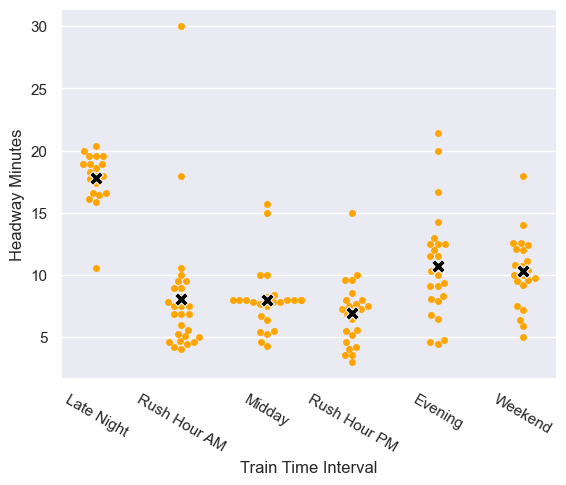

In [20]:
ax = sns.swarmplot(x='Train Time Interval', y='Headway Minutes', data=trip_interval_route_freq_trimmed, color='orange')
df_means = trip_interval_route_freq_trimmed.groupby(['Train Time Interval'])['Headway Minutes'].agg("mean").reset_index()
sns.scatterplot(x='Train Time Interval', y='Headway Minutes', marker='X', color='black', s=100, zorder=3, ax=ax, legend=False, data=df_means)
plt.xticks(rotation=330)
# plt.savefig("../saved_data/interval_headways.png", bbox_inches='tight') 

## Hourly

In [24]:
hourly_route_trip_freq

,index,route_id,day_of_week,departure_hour,trains_per_hour,headway_seconds,headway_minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
0,0,1,Saturday,0,3,"1,200",20,3425,57,6
1,1,1,Saturday,1,3,"1,200",20,3425,57,6
2,2,1,Saturday,2,3,"1,200",20,3425,57,6
3,3,1,Saturday,3,3,"1,200",20,3425,57,6
4,4,1,Saturday,4,3,"1,200",20,3425,57,6
...,...,...,...,...,...,...,...,...,...,...
1592,1664,W,Weekday,19,6,600,10,2662,44,9
1593,1665,W,Weekday,20,6,600,10,2662,44,9
1594,1666,W,Weekday,21,3,"1,200",20,2662,44,4
1595,1667,Z,Weekday,7,4,900,15,2985,50,7


In [27]:
hourly_route_trip_freq['day_hour'] = [hourly_route_trip_freq['day_of_week'][idx] + "_" \
                                        + str(hourly_route_trip_freq['departure_hour'][idx])
                                            for idx in range(hourly_route_trip_freq.shape[0])]
hourly_route_trip_freq[['route_id', 'day_hour', 'Avg_num_trains_running']].sort_values(
                                                    by='Avg_num_trains_running', ascending=False)[0:5]

,route_id,day_hour,Avg_num_trains_running
856,F,Weekday_7,49
857,F,Weekday_8,42
866,F,Weekday_17,39
867,F,Weekday_18,39
127,2,Weekday_7,38


In [28]:
hourly_number_of_trains_dict = {}
for value in hourly_route_trip_freq['day_hour'].unique():
    hourly_avg_num_trains = hourly_route_trip_freq[hourly_route_trip_freq['day_hour']==value
                                                                                ]['Avg_num_trains_running'].sum()
    hourly_number_of_trains_dict[value] = round(hourly_avg_num_trains, 1)
train_time_hourly_df = pd.DataFrame.from_dict(hourly_number_of_trains_dict, orient='index'
                                                , columns=['Avg_number_of_trains_in_hour'])

### Most frequent number of trains running

In [29]:
# most frequent hours to use the subway
train_time_hourly_df.sort_values(by='Avg_number_of_trains_in_hour', ascending=False)[0:10]

,Avg_number_of_trains_in_hour
Weekday_16,498
Weekday_7,488
Weekday_8,476
Weekday_17,440
Weekday_15,416
Weekday_18,412
Weekday_9,412
Weekday_6,400
Weekday_19,396
Weekday_13,390


### Least frequent number of trains running

In [30]:
# least frequent hours to use the subway
train_time_hourly_df.sort_values(by='Avg_number_of_trains_in_hour')[0:10]

,Avg_number_of_trains_in_hour
Saturday_3,124
Saturday_2,124
Sunday_4,124
Sunday_2,124
Sunday_3,124
Weekday_2,124
Weekday_3,124
Weekday_0,125
Weekday_1,125
Saturday_1,125


### Plotting number of trains runnings by Hour 

In [31]:
train_time_hourly_df_day = [x.split("_")[0] for x in train_time_hourly_df.index.values]
train_time_hourly_df_hour = [x.split("_")[1] for x in train_time_hourly_df.index.values]
train_time_hourly_df.columns = ['Avg Number of Trains in an Hour']
train_time_hourly_df['Day'] = train_time_hourly_df_day
train_time_hourly_df['Hour'] = train_time_hourly_df_hour

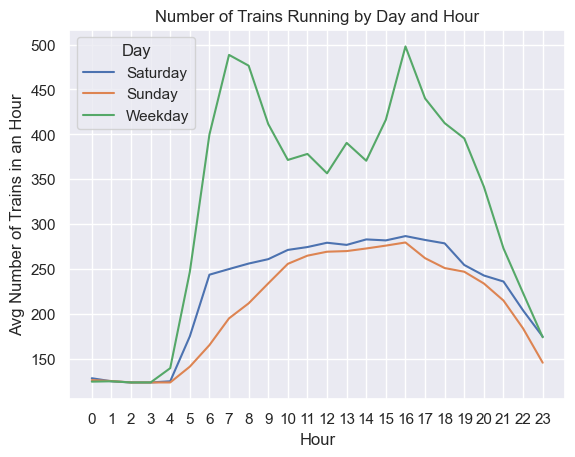

In [33]:
hourly_number_of_trains_by_day = sns.lineplot(data=train_time_hourly_df, x='Hour'
                                       , y='Avg Number of Trains in an Hour', hue='Day')
hourly_number_of_trains_by_day.set_title('Number of Trains Running by Day and Hour')
fig = hourly_number_of_trains_by_day.get_figure()
# fig.savefig("../saved_data/hourly_number_of_trains_by_day.png") 

# Data Visualizations

In [39]:
route_frequency_by_day_trimmed = route_frequency_by_day[route_frequency_by_day['headway_minutes']<=20]

In [40]:
# the route length shifts variabley so the frequency calculations are incorrect
sorted_routes = route_frequency_by_day_trimmed[route_frequency_by_day_trimmed
                                 ['day_of_week']=='Weekday'].sort_values(by='trains_per_hour')['route_id'].values


## Daily Average Frequency

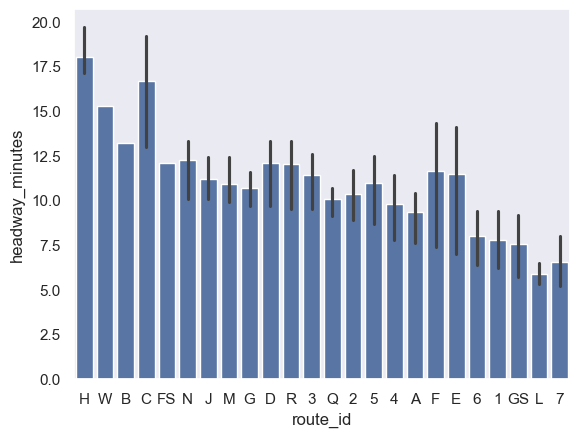

In [41]:
# with error bar 
ax = sns.barplot(data = route_frequency_by_day_trimmed, x = 'route_id', y='headway_minutes'
                 , order=sorted_routes)
#     ax.title(interval)
ax.grid(axis='y')
plt.show()

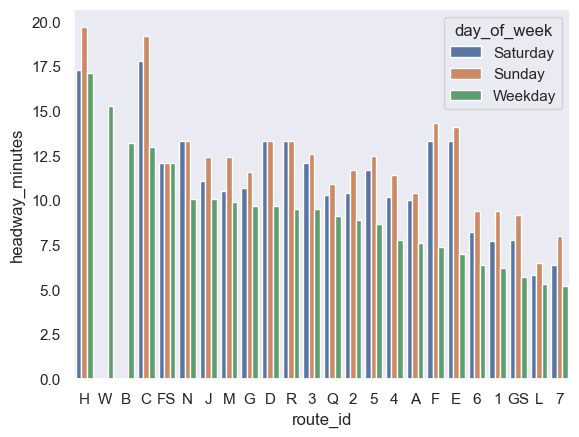

In [42]:
# separated by day 
ax = sns.barplot(data = route_frequency_by_day_trimmed, x = 'route_id', y='headway_minutes'
                 , hue='day_of_week', order=sorted_routes)
#     ax.title(interval)
ax.grid(axis='y')
plt.show()

## Frequency by Interval

Late Night


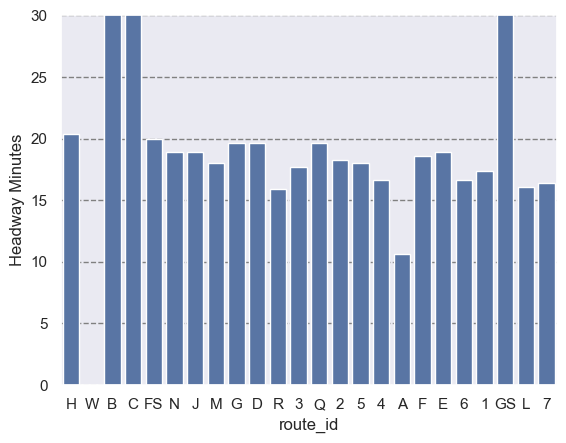

Rush Hour AM


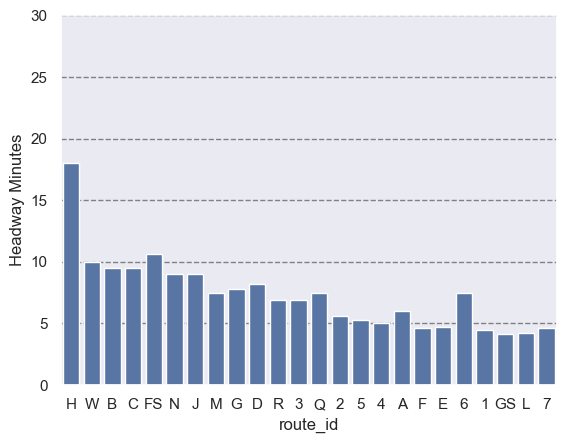

Midday


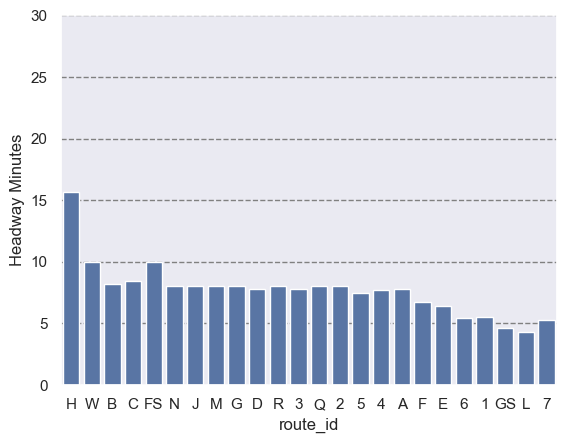

Rush Hour PM


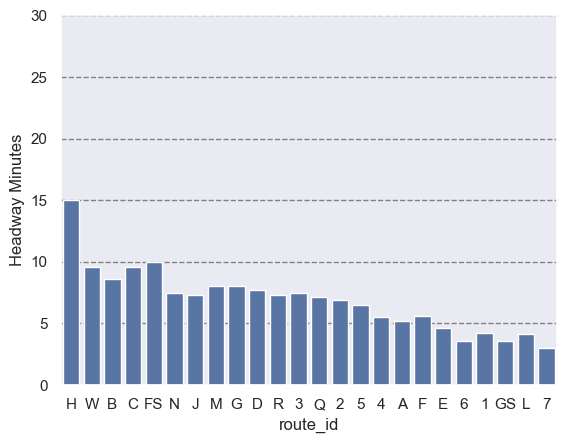

Evening


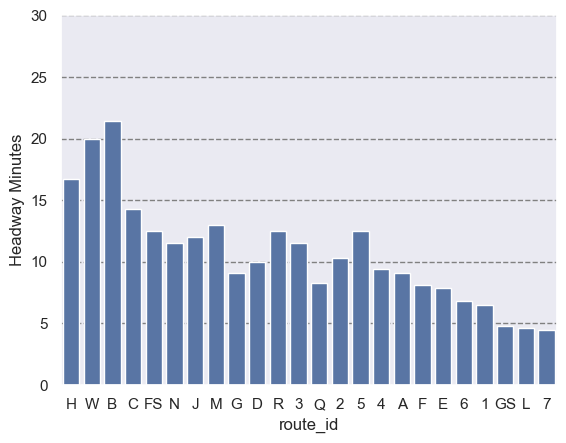

Weekend


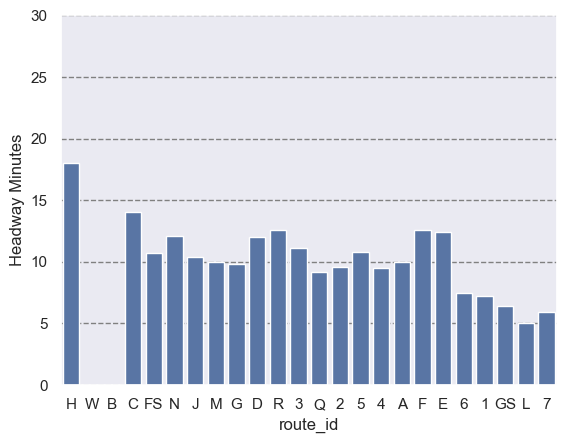

In [43]:
for interval in time_of_day_sorting.keys():
    print(interval)
    ax = sns.barplot(data=trip_interval_route_freq[trip_interval_route_freq
                                    ['Train Time Interval']==interval]
                                 , x = 'route_id', y='Headway Minutes', order=sorted_routes)
#     ax.title(interval)
    ax.grid(color='gray', linestyle='dashed')
    ax.grid(axis='x')
    ax.set_ylim(ymin=0, ymax=30)
    plt.show()

### Best and Worst Performers by Time of Day

In [47]:
# lowest  -- removing inf values first
# it's a tie for worst so let's just make it SIR lol 
trip_interval_route_freq_trimmed[trip_interval_route_freq_trimmed['Headway Minutes'] <= 20].sort_values(
    by='Headway Minutes').drop_duplicates(subset='Train Time Interval', keep='last')

,route_id,Train Time Interval,trains_per_hour,headway_seconds,Headway Minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
96,H,Rush Hour PM,4,900,15,602,10,1
70,H,Midday,4,939,16,602,10,1
42,H,Rush Hour AM,3,"1,080",18,602,10,1
145,H,Weekend,3,"1,080",18,602,10,1
13,FS,Late Night,3,"1,200",20,405,7,1
129,W,Evening,3,"1,200",20,2662,44,4


In [48]:
trip_interval_route_freq[trip_interval_route_freq['Headway Minutes'] <= 20].sort_values(
    by='Headway Minutes', ascending=False).drop_duplicates(subset='Train Time Interval', keep='last')

,route_id,Train Time Interval,trains_per_hour,headway_seconds,Headway Minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
7,A,Late Night,6,635,11,4900,82,15
147,L,Weekend,12,303,5,2239,37,15
111,7,Evening,13,273,4,2246,37,16
72,L,Midday,14,257,4,2239,37,17
41,GS,Rush Hour AM,15,245,4,90,2,1
85,7,Rush Hour PM,20,180,3,2246,37,25


## Visualizing Hourly Frequency within a Service

In [49]:
# plot the headway minutes for a single line
l_train_hourly_df = hourly_route_trip_freq[hourly_route_trip_freq['route_id']=='L']
l_train_hourly_df_trimmed = l_train_hourly_df[['day_of_week', 'departure_hour', 'headway_seconds'
                                               , 'headway_minutes', 'Avg_num_trains_running', 'day_hour']]

<Axes: xlabel='departure_hour', ylabel='headway_minutes'>

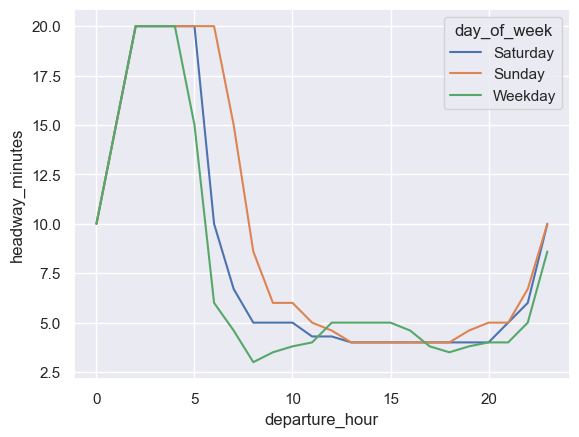

In [50]:
sns.lineplot(data=l_train_hourly_df_trimmed, x='departure_hour', y='headway_minutes', hue='day_of_week')

## Comparing All Services
at rush hour

In [51]:
all_rush_hour_trains = trip_interval_route_freq[
                            trip_interval_route_freq['Train Time Interval'].str.contains("Rush")]

In [52]:
all_rush_hour_trains.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 24 to 104
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                52 non-null     object 
 1   Train Time Interval     52 non-null     object 
 2   trains_per_hour         52 non-null     float64
 3   headway_seconds         52 non-null     float64
 4   Headway Minutes         52 non-null     float64
 5   route_time_seconds      52 non-null     int64  
 6   route_time_minutes      52 non-null     float64
 7   Avg_num_trains_running  52 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.7+ KB


In [57]:
all_rush_hour_trains = trip_interval_route_freq[
                            trip_interval_route_freq['Train Time Interval'].str.contains("Rush")]
rush_hour_trains_avg = all_rush_hour_trains.groupby('route_id')['Headway Minutes'].sum() / 2
# rush_hour_trains_avg = rush_hour_trains_avg[rush_hour_trains_avg['Headway Minutes']<=20]

In [59]:
rush_hour_trains_avg = rush_hour_trains_avg.sort_values(ascending=False).reset_index()
# removing the FX
rush_hour_trains_avg = rush_hour_trains_avg[rush_hour_trains_avg['Headway Minutes']<=20]

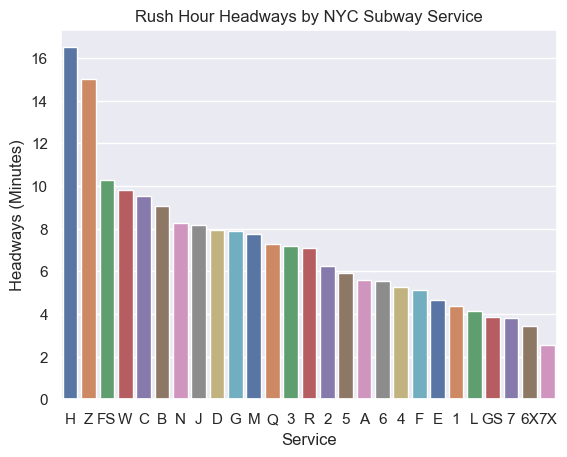

In [65]:
# sns.set(style="line")
ax = sns.barplot(data=rush_hour_trains_avg, x='route_id', y='Headway Minutes', palette='deep')
ax.set_title('Rush Hour Headways by NYC Subway Service')
ax.set_ylabel('Headways (Minutes)')
ax.set_xlabel('Service')
# ax.grid(b=True, axis='y')
fig = ax.get_figure()
# fig.savefig("../saved_data/service_comparison_rush_hour.png") 